## Experiment: caricatures with transform invariant adversarial examples 

Might help us figure out how each layer "reacts" to an adversarial example 

In [ ]:
!pip install torch-dreams 

In [ ]:
!wget -O elephant.jpg "https://c402277.ssl.cf1.rackcdn.com/photos/885/images/carousel_small/African_Elephant_7.27.2012_whytheymatter_HI_58709.jpg?1345580947"

In [ ]:
!wget -O imagenet_classes.pkl "https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl"

In [4]:
## loads up imagenet classes into a dictionary 
import pickle
with open('imagenet_classes.pkl', 'rb') as f:
    imagenet_class_names = dict(pickle.load(f))

In [5]:
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams.dreamer import dreamer

import torch
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms

## Picking a model and a image 

In [ ]:
model = models.googlenet(pretrained= True).eval().cuda()
dreamy_boi = dreamer(model = model, quiet= False, device= 'cuda')

In [7]:
dict(model.named_children()).keys()   ## reference for layer names 

dict_keys(['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'avgpool', 'dropout', 'fc'])

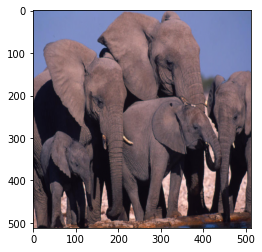

In [9]:
im_original = cv2.cvtColor(cv2.imread('elephant.jpg'), cv2.COLOR_BGR2RGB)/255.
im_original = cv2.resize(im_original, (512,512))  ## resize to a smaller size for faster computations 
im = im_original
height , width , channels = im.shape
plt.imshow(im)
plt.show()

In [10]:
image_tensor = torch.tensor(im).permute(-1,0,1).unsqueeze(0)
t = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

image_tensor_transformed = t(image_tensor).float().cuda()

## Setting up transforms to "train" the adversarial example

In [11]:
## these transforms would be used when "training" the adversarial example
dreamy_boi.get_default_transforms(
    rotate = 15,  
    scale_max = 1.2,  
    scale_min = 0.5, 
    translate_x = 0.1,
    translate_y = 0.1,
)

In [12]:
import torch.nn as nn 

class TransformRobustPGD(nn.Module):
    def __init__(self, transforms, model, label):
        """
        took some reference from:
            https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/
        """
        super().__init__()
        self.transforms = transforms 
        self.model = model
        self.label = label ## torch.tensor([4])  

    def forward(self, image_tensor, iters = 10, batch_size = 10):
        
        image_tensor_original = image_tensor.clone().detach()
        image_tensor = image_tensor_original.clone().requires_grad_()
        loss_func = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam([image_tensor], lr = 1e-2)

        for i in range(iters):

            optimizer.zero_grad()
            batch = image_tensor.repeat_interleave(batch_size, dim = 0)
            labels = self.label.repeat_interleave(batch_size, dim = 0)
            
            batch = self.transforms(batch)

            # plt.imshow(batch[0].permute(1,2,0).cpu().detach())
            # plt.show()
            outs = self.model(batch)

            loss = loss_func(outs, labels)
            loss += torch.abs(image_tensor - image_tensor_original).mean()

            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(loss.item())

        return image_tensor.detach()

## Generating an adversarial example

In [13]:
TARGET_CLASS_INDEX = 738  ## 738: 'pot, flowerpot'

teepee = TransformRobustPGD(
    transforms= dreamy_boi.transforms, ## can use any other transforms.Compose([blah blah something])
    model = dreamy_boi.model,
    label = torch.tensor([TARGET_CLASS_INDEX]).cuda()
)

In [ ]:
adversarial_image = teepee(image_tensor_transformed, iters = 150, batch_size =10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


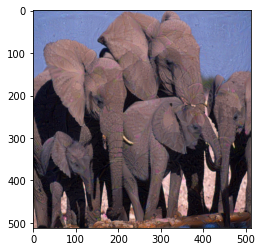

In [16]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

adversarial_img_chw = invTrans(adversarial_image)[0].permute(1,2,0).cpu()
plt.imshow(adversarial_img_chw)
plt.show()

In [17]:
pred = model(image_tensor_transformed)
print('pred on original:', torch.argmax(pred).item())

pred on original: 386


## How robust is the adversarial example over a random set of transforms ?

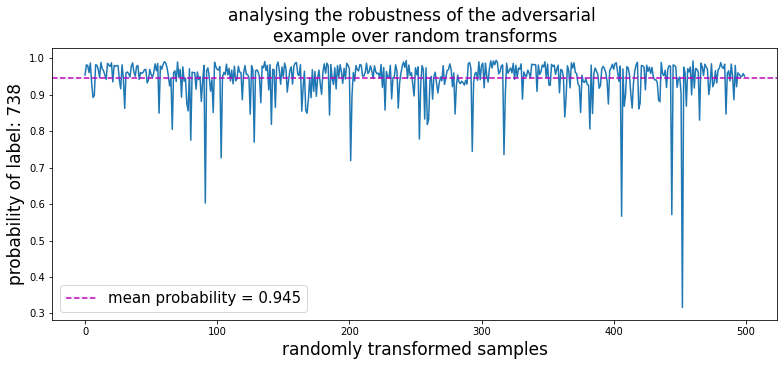

In [26]:
num_samples = 500

preds_all = torch.zeros(num_samples, 1000)

for i in range(num_samples):
    with torch.no_grad():
        adversarial_image_transformed = dreamy_boi.transforms(adversarial_image)

        pred = model(adversarial_image_transformed)[0]
        preds_all[i] = pred

preds_all = torch.softmax(preds_all, dim = 1)
pred_mean = preds_all.mean(dim = 0)

label = 'analysing the robustness of the adversarial \nexample over random transforms'
plt.figure(figsize=(13,5))
plt.plot(preds_all[:,TARGET_CLASS_INDEX])
plt.title(label, fontsize = 17)
plt.ylabel('probability of label: 738', fontsize = 17)
plt.xlabel('randomly transformed samples', fontsize = 17)
plt.axhline(preds_all[:,TARGET_CLASS_INDEX].mean(), linestyle = '--', c = 'm', label = 'mean probability = ' + str(round(preds_all[:,TARGET_CLASS_INDEX].mean().item(), 3)))
plt.legend(fontsize=15)
plt.show()

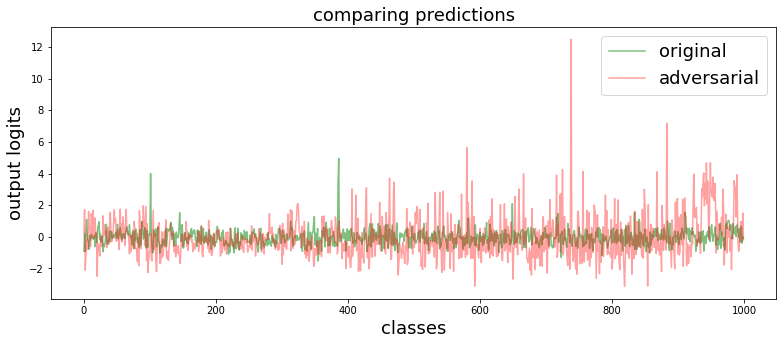

In [19]:
plt.figure(figsize=(13,5))
plt.plot(model(image_tensor_transformed.cuda().float())[0].cpu().detach(), label = 'original', alpha = 0.5, c = 'g')
plt.plot(model(adversarial_image.cuda().float())[0].cpu().detach(), label = 'adversarial', alpha = 0.37, c = 'r')
plt.legend(fontsize = 18)
plt.ylabel('output logits',fontsize = 18)
plt.xlabel('classes', fontsize = 18)
plt.title('comparing predictions', fontsize = 18)
plt.show()

## How does `inception4d` "react" ?

In [20]:
image_param = dreamy_boi.caricature(
    input_tensor = image_tensor_transformed, 
    layers = [model.inception4d],  
    power= 1.2,                     
    iters = 120,
)

image_param_adv = dreamy_boi.caricature(
    input_tensor = adversarial_image, 
    layers = [model.inception4d],
    power= 1.2,                     
    iters = 120,
)

100%|██████████| 120/120 [00:05<00:00, 20.30it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


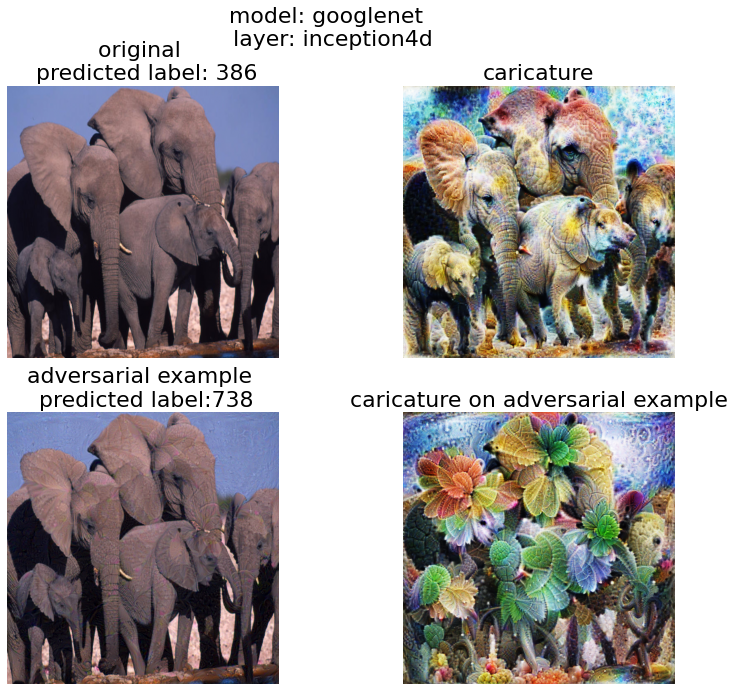

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2 , figsize = (13,11))

pred_original_label = torch.argmax(model(image_tensor_transformed.cuda().float())[0].cpu().detach()).item()
pred_adv_label = torch.argmax(preds_all.mean(dim = 0)).item()


fig.suptitle('model: googlenet \n layer: inception4d', fontsize = 22)

ax[1][0].imshow(adversarial_img_chw)
ax[0][0].imshow(im_original)

ax[0][1].imshow(image_param)
ax[1][1].imshow(image_param_adv)

ax[0][0].set_title('original \n predicted label: ' + str(pred_original_label), fontsize = 22)
ax[1][0].set_title('adversarial example \n predicted label:' + str(pred_adv_label) , fontsize = 22)

ax[0][1].set_title('caricature', fontsize = 22)
ax[1][1].set_title('caricature on adversarial example', fontsize = 22)

for i in range(4):
    ax.flat[i].axis('off')

## Scaling up to visualize some more layers 

In [22]:
## wrote it in a fancy dictionary just for the names in the subplots 
layers_to_watch = {
                   'inception4b': model.inception4b,
                   'inception4c': model.inception4c,
                   'inception4d': model.inception4d,
                   'inception4e': model.inception4e,
}

In [ ]:
outs =  []
outs_adv = []

for layer in list(layers_to_watch.values()):

    image_param = dreamy_boi.caricature(
        input_tensor = image_tensor_transformed, 
        layers = [layer],              
        power= 1.2,                     
        iters = 120
    )
    

    image_param_adv = dreamy_boi.caricature(
        input_tensor = adversarial_image, 
        layers = [layer],               
        power= 1.2,                     
        iters = 120
    )
    outs.append(image_param)
    outs_adv.append(image_param_adv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


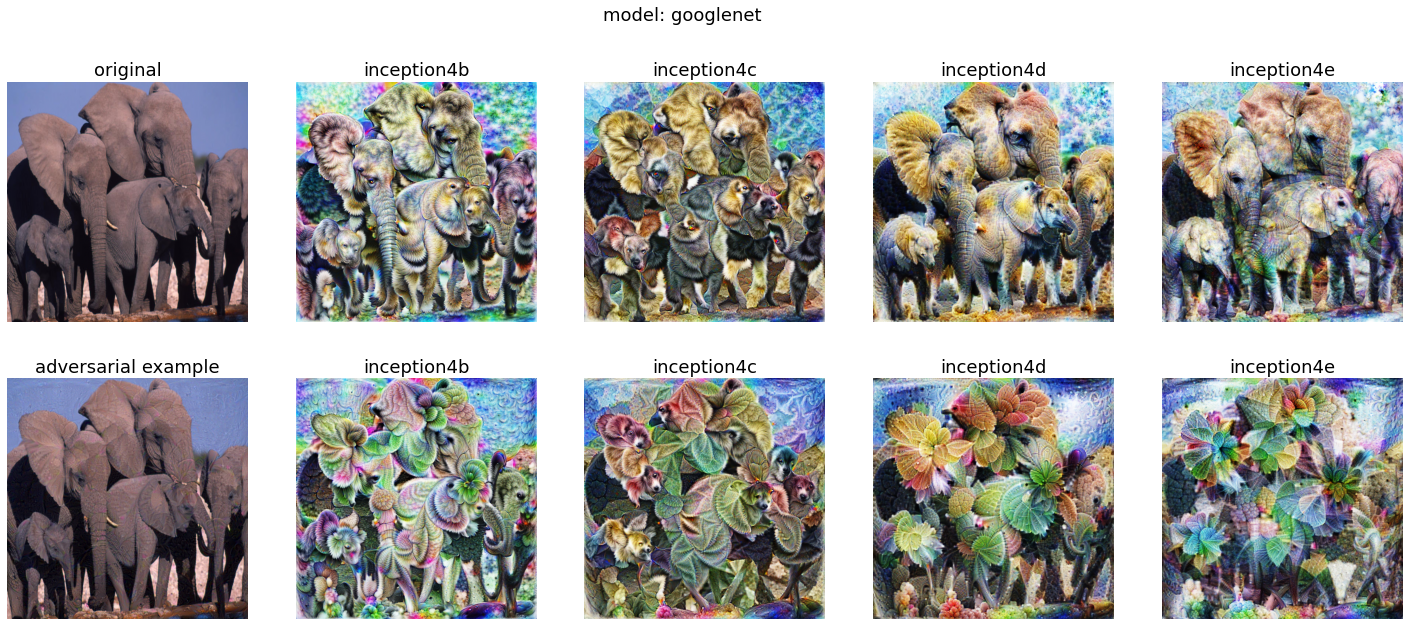

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=len(layers_to_watch) + 1, figsize = (25,10))

names = list(layers_to_watch.keys())

fig.suptitle('model: googlenet', fontsize = 18)

ax[0][0].imshow(im)
ax[0][0].set_title('original', fontsize = 18)

ax[1][0].imshow(adversarial_img_chw)
ax[1][0].set_title('adversarial example', fontsize = 18)

ax[0][0].axis('off')
ax[1][0].axis('off')


for i in range(1, len(layers_to_watch) + 1):
    ax[0][i].imshow(outs[i-1])
    ax[0][i].set_title(names[i-1], fontsize = 18)
    ax[1][i].imshow(outs_adv[i-1])
    ax[1][i].set_title(names[i-1], fontsize = 18)

    
    ax[0][i].axis('off')
    ax[1][i].axis('off')

